In [1]:
%pip install pycocotools
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [202]:
import torch
import torch.nn as nn
from torchvision.datasets import CocoDetection
from torchvision.ops import focal_loss, box_iou, nms, MultiScaleRoIAlign
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor

from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torchvision.transforms as T
from torchvision.transforms import functional as f
import torch.nn.functional as F
from torchvision import models
from pathlib import Path
from torchvision.models.detection.image_list import ImageList
from torchvision.ops import box_convert

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
cur_path = Path(os.getcwd())
cur_path

WindowsPath('C:/Users/Alex/Desktop/nure/DL_2')

In [5]:
coco_path = cur_path / '../..' / 'deka codes' / 'datasets' / 'coco' / 'images'
path = coco_path / 'val2017'
annotation_path = coco_path / 'annotations' / 'instances_val2017.json'
path

WindowsPath('C:/Users/Alex/Desktop/nure/DL_2/../../deka codes/datasets/coco/images/val2017')

In [56]:

class DetectionTransform:
    def __init__(self, size=(224,224), mean=None, std=None):
        self.size = size
        self.mean = mean or [0.485, 0.456, 0.406]
        self.std  = std  or [0.229, 0.224, 0.225]

    def __call__(self, image, target):
        # 1) original PIL size
        orig_w, orig_h = image.size

        # 2) resize image then to-tensor + normalize
        image = f.resize(image, self.size)
        image = f.to_tensor(image)
        image = f.normalize(image, self.mean, self.std)

        # 3) build boxes tensor safely
        raw_boxes = [obj['bbox'] for obj in target]  # list of [x,y,w,h]
        if len(raw_boxes) > 0:
            boxes = torch.tensor(raw_boxes, dtype=torch.float32)
            # convert xywh→xyxy
            x1 = boxes[:,0]
            y1 = boxes[:,1]
            x2 = x1 + boxes[:,2]
            y2 = y1 + boxes[:,3]
            boxes = torch.stack([x1, y1, x2, y2], dim=1)
            # scale to new resolution
            w_scale = self.size[1] / orig_w
            h_scale = self.size[0] / orig_h
            boxes *= torch.tensor([w_scale, h_scale, w_scale, h_scale])
        else:
            # zero boxes → shape (0,4)
            boxes = torch.zeros((0,4), dtype=torch.float32)

        # 4) build labels tensor (empty if no boxes)
        labels = torch.tensor(
            [obj['category_id'] for obj in target],
            dtype=torch.int64
        ) if len(raw_boxes)>0 else torch.zeros((0,), dtype=torch.int64)

        # FILTER ONLY CLASS PERSON !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        keep = (labels == 1)
        boxes = boxes[keep]
        # now map person→1 (positive), and background→0 implicitly
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        # 5) return image tensor + dict
        return image, {'boxes': boxes, 'labels': labels}

In [58]:

# 1) image‐only tensor+normalize pipeline
img_norm = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# 2) single transforms fn
def custom_transforms(image, target):
    # record old size
    orig_w, orig_h = image.size

    # resize image
    new_h, new_w = 224, 224
    image = f.resize(image, [new_h, new_w])

    # scale bboxes
    x_scale, y_scale = new_w / orig_w, new_h / orig_h
    for obj in target:
        x, y, w, h = obj['bbox']
        obj['bbox'] = [x * x_scale, y * y_scale, w * x_scale, h * y_scale]

    # now tensor + normalize
    image, _ = img_norm(image), None
    return image, target



dataset = CocoDetection(
    root=path,
    annFile=annotation_path,
    transforms=DetectionTransform(size=(224,224))# custom_transforms,
)

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!


In [60]:
torch.manual_seed(42)
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [62]:
classes = sorted({t.item() for imgs, targets in dataset for t in targets['labels']})
class2id = {cls: i + 1 for i, cls in enumerate(classes)}
num_classes = len(classes) + 1
classes

[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1])


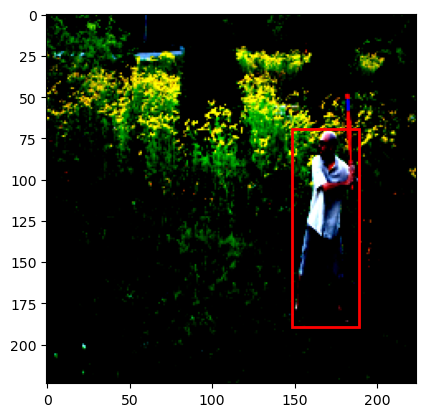

In [84]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img, ann = train_ds[3]   # first sample
img = img.permute(1,2,0).numpy()  # C×H×W → H×W×C

fig, ax = plt.subplots(1)
ax.imshow(img)
print(ann['labels'])
for box in ann['boxes']:
    x1, y1, x2, y2 = box.tolist()      # xyxy
    w, h = x2 - x1, y2 - y1            # convert to w,h
    rect = patches.Rectangle(
        (x1, y1),                      # corner
        w, h,                          # width, height
        edgecolor='r', fill=False, linewidth=2
    )
    ax.add_patch(rect)

plt.show()


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
def prepare_targets(raw_targets, device):
    new_targets = []
    for t in raw_targets:
        # boxes are already a FloatTensor [M,4] in xyxy from your transform
        boxes = t['boxes'].to(device)

        # map raw category_ids → 1..C-1
        labels = torch.tensor(
            [ class2id[int(cat)] for cat in t['labels'].tolist() ],
            dtype=torch.int64, device=device
        )
        new_targets.append({'boxes': boxes, 'labels': labels})
    return new_targets



In [14]:
def encode_boxes(anchors, gt_boxes):
    xa, ya, wa, ha = anchors.unbind(dim=1)
    xg, yg, wg, hg = gt_boxes.unbind(dim=1)
    tx = (xg - xa) / wa
    ty = (yg - ya) / ha
    tw = torch.log(wg / wa)
    th = torch.log(hg / ha)
    return torch.stack([tx, ty, tw, th], dim=1)

def decode_boxes(anchors_xyxy, deltas):
    """
    anchors_xyxy: Tensor[N,4] in [x1,y1,x2,y2]
    deltas:       Tensor[N,4] in [tx,ty,tw,th] from your head
    returns:      Tensor[N,4] in [x1,y1,x2,y2]
    """

    anchors_xywh = box_convert(anchors_xyxy, in_fmt="xyxy", out_fmt="xywh")
    xa, ya, wa, ha = anchors_xywh.unbind(dim=1)
    tx, ty, tw, th = deltas.unbind(dim=1)

    px = tx * wa + xa
    py = ty * ha + ya
    pw = torch.exp(tw) * wa
    ph = torch.exp(th) * ha

    pred_xywh = torch.stack([px, py, pw, ph], dim=1)
    return box_convert(pred_xywh, in_fmt="xywh", out_fmt="xyxy")

def match_anchors(anchors_xyxy, gt_xyxy, gt_labels,
                  pos_iou_thresh=0.5, neg_iou_thresh=0.4):
    if gt_xyxy.numel() == 0:
        N = anchors_xyxy.shape[0]
        return (
            torch.zeros(N, dtype=torch.long,   device=anchors_xyxy.device),
            torch.zeros((N,4), dtype=torch.float32, device=anchors_xyxy.device)
        )

    ious       = box_iou(anchors_xyxy, gt_xyxy)  # (N,M)
    max_iou, idxs = ious.max(dim=1)

    cls_t  = torch.zeros_like(max_iou, dtype=torch.long)
    cls_t[max_iou >= pos_iou_thresh] = gt_labels[idxs[max_iou >= pos_iou_thresh]]
    ignore = (max_iou >= neg_iou_thresh) & (max_iou < pos_iou_thresh)
    cls_t[ignore] = -1

    an_xywh = box_convert(anchors_xyxy, in_fmt="xyxy", out_fmt="xywh")
    gt_xywh = box_convert(gt_xyxy[idxs],     in_fmt="xyxy", out_fmt="xywh")
    reg_t   = encode_boxes(an_xywh, gt_xywh)

    return cls_t, reg_t


In [329]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

def train_one_epoch(model, optimizer, data_loader, device, epoch, lr_scheduler=None):
    model.train()
    total_cls  = 0.0
    total_bbox = 0.0

    loop = tqdm(data_loader, desc=f"Epoch {epoch} ▶️ train", leave=False)
    for images, raw_targets in loop:
        images  = [img.to(device) for img in images]
        targets = prepare_targets(raw_targets, device)

        loss_dict = model(images, targets)

        # grab classification + box‐regression losses only
        cls_loss  = loss_dict.get('cls_loss',      # custom head
                                  loss_dict.get('loss_classifier', torch.tensor(0., device=device)))
        bbox_loss = loss_dict.get('reg_loss',      # custom head
                                  loss_dict.get('loss_box_reg',     torch.tensor(0., device=device)))

        loss = cls_loss + bbox_loss
        loop.set_postfix({
            "cls":  f"{cls_loss.item():.3f}",
            "bbox": f"{bbox_loss.item():.3f}",
            "tot":  f"{loss.item():.3f}"
        })
        loss = sum(value for value in loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_cls  += cls_loss.item()
        total_bbox += bbox_loss.item()



    n = len(data_loader)
    return {
        'train/cls_loss':   total_cls  / n,
        'train/bbox_loss':  total_bbox / n,
        'train/total_loss': (total_cls + total_bbox) / n,
    }

    n = len(data_loader)
    return {
        # 'train/cls_loss': total_cls / n,
        # 'train/reg_loss': total_reg / n,
        'train/total_loss': total_loss / n,
    }

def validate(model, data_loader, device, iou_threshold=0.5, score_thresh=0.5):
    model.eval()
    map_metric = MeanAveragePrecision(iou_type='bbox', class_metrics=True)

    # for precision/recall/iou
    total_tp = total_fp = total_fn = 0
    total_iou = 0.0
    count_iou = 0

    with torch.no_grad():
        for images, raw_targets in data_loader:
            images = [img.to(device) for img in images]
            gt = prepare_targets(raw_targets, device)
            preds = model(images)

            formatted_preds = []
            formatted_tgts  = []
            for p, t in zip(preds, gt):
                # filter low‐score
                keep = p['scores'] > score_thresh
                boxes = p['boxes'][keep].cpu()
                scores= p['scores'][keep].cpu()
                labels= p['labels'][keep].cpu()

                formatted_preds.append({'boxes': boxes, 'scores': scores, 'labels': labels})
                formatted_tgts.append({'boxes': t['boxes'].cpu(), 'labels': t['labels'].cpu()})

                # --- compute TP/FP/FN & IoU per image ---
                gt_boxes   = t['boxes'].cpu()
                pred_boxes = boxes

                if gt_boxes.numel() == 0:
                    # everything is false positive
                    total_fp += pred_boxes.shape[0]
                    continue

                if pred_boxes.numel() == 0:
                    # everything is false negative
                    total_fn += gt_boxes.shape[0]
                    continue

                # IoU matrix [P, G]
                ious = box_iou(pred_boxes, gt_boxes)

                matched_gt = set()
                # for each pred, see if it matches an unmatched GT
                for j in range(ious.shape[0]):
                    max_iou, idx = ious[j].max(dim=0)
                    if max_iou >= iou_threshold and idx.item() not in matched_gt:
                        total_tp += 1
                        total_iou += max_iou.item()
                        count_iou += 1
                        matched_gt.add(idx.item())
                    else:
                        total_fp += 1
                # any GT not matched is a FN
                total_fn += (ious.shape[1] - len(matched_gt))

            # update mean AP
            map_metric.update(formatted_preds, formatted_tgts)

    results = map_metric.compute()
    precision = total_tp / (total_tp + total_fp) if (total_tp+total_fp)>0 else 0.0
    recall    = total_tp / (total_tp + total_fn) if (total_tp+total_fn)>0 else 0.0
    avg_iou   = total_iou / count_iou if count_iou>0 else 0.0

    print(f"Validation ▶️ mAP@.50={results['map_50']:.4f}, "
          f"Precision={precision:.4f}, Recall={recall:.4f}, Avg IoU={avg_iou:.4f}")

    # collect metrics
    val_metrics = {
        'val/precision': precision,
        'val/recall': recall,
        'val/avg_iou': avg_iou,
        'val/map': results['map'].item(),
        'val/map_50': results['map_50'].item()
    }
    # optional: per‐class AP
    val_metrics['val/map_per_class'] = results['map_per_class'].cpu().tolist()

    return val_metrics


def run_training(model, train_loader, val_loader, optimizer, device, epochs, lr_scheduler=None):
    history = {'train': [], 'val': []}
    for epoch in range(1, epochs + 1):
        t_metrics = train_one_epoch(model, optimizer, train_loader, device, epoch, lr_scheduler)
        v_metrics = validate(model, val_loader, device)
        history['train'].append(t_metrics)
        history['val'].append(v_metrics)
        if lr_scheduler:
            lr_scheduler.step()
    return history


## Кастомний object detector

In [193]:
class RPNHead(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.cls_logits = nn.Conv2d(
            in_channels,
            num_anchors * num_classes,
            kernel_size=1
        )        
        self.bbox_pred = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)

    def forward(self, x):
        t = F.relu(self.conv(x))
        logits = self.cls_logits(t)               
        bbox_regs = self.bbox_pred(t)       
        return logits, bbox_regs


In [398]:
class SimpleDetector(nn.Module):
    def __init__(self, num_classes, backbone):
        super().__init__()
        self.backbone = backbone
        self.backbone.out_channels = 1280

        # 2) anchors (single feature-map level)
        self.anchor_gen = AnchorGenerator(
            sizes=((16, 32, 64, 128,),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )

        # 3) RPN head
        self.num_anchors = self.anchor_gen.num_anchors_per_location()[0]
        self.head = RPNHead(self.backbone.out_channels, self.num_anchors, num_classes)

        # 4) num of object classes (no “background” here – we use 0 as negative)
        self.num_classes = num_classes

    def forward(self, images, targets=None):
        """
        images: list of Tensors
        targets: list of dicts or None
        """
        images_tensor = torch.stack(images)
        sizes = [(img.shape[-2], img.shape[-1]) for img in images]
        image_list   = ImageList(images_tensor, sizes)
        feats        = self.backbone(images_tensor)

        cls_logits, bbox_regs = self.head(feats)
        anchors_list = self.anchor_gen(image_list, [feats])

        B, _, H, W = cls_logits.shape

        cls = cls_logits.view(B, self.num_anchors, self.num_classes, H, W)
        # → [B, H, W, A, num_classes] → [B, H*W*A, num_classes]
        cls = cls.permute(0, 3, 4, 1, 2).reshape(B, -1, self.num_classes)
     
        # — regression —
        # [B, A*4, H, W] → [B, A, 4, H, W]
        regs = bbox_regs.view(B, self.num_anchors, 4, H, W)
        # → [B, H, W, A, 4] → [B, H*W*A, 4]
        regs = regs.permute(0, 3, 4, 1, 2).reshape(B, -1, 4)
                 # rename for the rest of your code
        obj_logits, bbox_regs = cls, regs

        if self.training and targets is not None:
            total_cls, total_reg = 0.0, 0.0

            for i in range(B):
                anchors_i = anchors_list[i]  # Tensor[N,4]
                gt_boxes  = targets[i]['boxes']
                gt_labels = targets[i]['labels']

                cls_t, reg_t = match_anchors(anchors_i, gt_boxes, gt_labels,
                                            pos_iou_thresh=0.5, neg_iou_thresh=0.4)

                valid       = cls_t >= 0
                pos_mask    = (cls_t[valid] > 0).float()

                cls_loss = F.cross_entropy(
                    obj_logits[i][valid],      # [num_valid, num_classes]
                    cls_t[valid],              # [num_valid]
                    ignore_index=-1
                )

                pos_inds = cls_t > 0
                if pos_inds.any():
                    reg_loss = F.smooth_l1_loss(
                        bbox_regs[i][pos_inds],
                        reg_t[pos_inds],
                        beta=1.0
                    )
                else:
                    reg_loss = torch.tensor(0.0, device=feats.device)

                total_cls += cls_loss
                total_reg += reg_loss

            return {
                "cls_loss": total_cls / B,
                "reg_loss": total_reg / B
            }

        else:
            detections = []
            for i in range(B):
                anchors_i = anchors_list[i]                   # [N,4]
        
                # 1) [N, num_classes] → softmax over classes
                logits = obj_logits[i]                        # [N,C]
                probs  = F.softmax(logits, dim=1)             # [N,C]
        
                # 2) pick best class (skip class 0 = background)
                scores, labels = probs.max(dim=1)             # [N], [N]
                keep_mask = (labels > 0) & (scores > 0.2)     # filter BG & low‐score
        
                if not keep_mask.any():
                    detections.append({
                        "boxes":  torch.zeros((0,4), device=images_tensor.device),
                        "scores": torch.zeros((0,),   device=images_tensor.device),
                        "labels": torch.zeros((0,), dtype=torch.int64, device=images_tensor.device)
                    })
                    continue
        
                raw_boxes   = anchors_i[keep_mask]            # [K,4]
                raw_deltas  = bbox_regs[i][keep_mask]         # [K,4]
                boxes       = decode_boxes(raw_boxes, raw_deltas)
                scores_sel  = scores[keep_mask]
                labels_sel  = labels[keep_mask]
        
                keep2 = nms(boxes, scores_sel, iou_threshold=0.5)
        
                detections.append({
                    "boxes":  boxes[keep2],
                    "scores": scores_sel[keep2],
                    "labels": labels_sel[keep2]
                })
        
            return detections


In [400]:
backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1).features
backbone = backbone.to(device)
for p in backbone.parameters():
    p.requires_grad = False
simple_model = SimpleDetector(num_classes, backbone=backbone)
simple_model.to(device)

SimpleDetector(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, e

In [401]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, simple_model.parameters()), lr=5e-4, weight_decay=1e-4)
# optimizer = torch.optim.SGD(simple_model.parameters(), lr=5e-3, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
history = run_training(simple_model, loader, val_loader, optimizer, device, epochs=10, lr_scheduler=lr_scheduler)


Validation ▶️ mAP@.50=0.0000, Precision=0.0000, Recall=0.0000, Avg IoU=0.0000


Validation ▶️ mAP@.50=0.0110, Precision=0.5000, Recall=0.0154, Avg IoU=0.6089


Validation ▶️ mAP@.50=0.0166, Precision=0.4304, Recall=0.0275, Avg IoU=0.6114


Validation ▶️ mAP@.50=0.0434, Precision=0.3954, Recall=0.0628, Avg IoU=0.6363


Validation ▶️ mAP@.50=0.0377, Precision=0.4103, Recall=0.0648, Avg IoU=0.6288


Validation ▶️ mAP@.50=0.0465, Precision=0.4712, Recall=0.0696, Avg IoU=0.6359


Validation ▶️ mAP@.50=0.0519, Precision=0.4798, Recall=0.0721, Avg IoU=0.6318


Validation ▶️ mAP@.50=0.0517, Precision=0.4493, Recall=0.0753, Avg IoU=0.6305


Validation ▶️ mAP@.50=0.0479, Precision=0.4942, Recall=0.0684, Avg IoU=0.6300


Validation ▶️ mAP@.50=0.0540, Precision=0.4517, Recall=0.0757, Avg IoU=0.6276


## FasterRCNN

In [406]:
backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1).features
backbone = backbone.to(device)

In [408]:
backbone.out_channels = backbone[-1][0].out_channels

In [410]:
for param in backbone.parameters():
    param.requires_grad = False

In [411]:
anchor_generator = AnchorGenerator(
    sizes=((16, 32, 64, 128),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

In [414]:
roi_pooler = MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)


In [415]:
in_channels_head = backbone.out_channels * 7 * 7
representation_size = 128
box_head = TwoMLPHead(
    in_channels=in_channels_head,
    representation_size=representation_size
)

# 5) make a predictor off that (256 → num_classes)
box_predictor = FastRCNNPredictor(
    in_channels=representation_size,
    num_classes=num_classes
)

# 6) assemble the Faster R-CNN
rcnn_model = FasterRCNN(
    backbone=backbone,
    num_classes=None,                   # we’ll plug in our own predictor
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
    box_head=box_head,
    box_predictor=box_predictor
).to(device)
rcnn_model.rpn.pre_nms_top_n_test  = 100
rcnn_model.rpn.post_nms_top_n_test = 100

In [418]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, rcnn_model.parameters()), lr=5e-4, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
history = run_training(rcnn_model, loader, val_loader, optimizer, device, epochs=10, lr_scheduler=lr_scheduler)

Validation ▶️ mAP@.50=0.0258, Precision=0.2854, Recall=0.0555, Avg IoU=0.6283


Validation ▶️ mAP@.50=0.0869, Precision=0.2444, Recall=0.1850, Avg IoU=0.6521


Validation ▶️ mAP@.50=0.0797, Precision=0.3848, Recall=0.1372, Avg IoU=0.6618


Validation ▶️ mAP@.50=0.0922, Precision=0.4321, Recall=0.1352, Avg IoU=0.6635


Validation ▶️ mAP@.50=0.1332, Precision=0.2722, Recall=0.2231, Avg IoU=0.6622


Validation ▶️ mAP@.50=0.1428, Precision=0.2832, Recall=0.2304, Avg IoU=0.6779


Validation ▶️ mAP@.50=0.1441, Precision=0.2712, Recall=0.2368, Avg IoU=0.6795


Validation ▶️ mAP@.50=0.1398, Precision=0.2883, Recall=0.2271, Avg IoU=0.6753


Validation ▶️ mAP@.50=0.1411, Precision=0.2901, Recall=0.2316, Avg IoU=0.6739


Validation ▶️ mAP@.50=0.1437, Precision=0.3018, Recall=0.2348, Avg IoU=0.6764


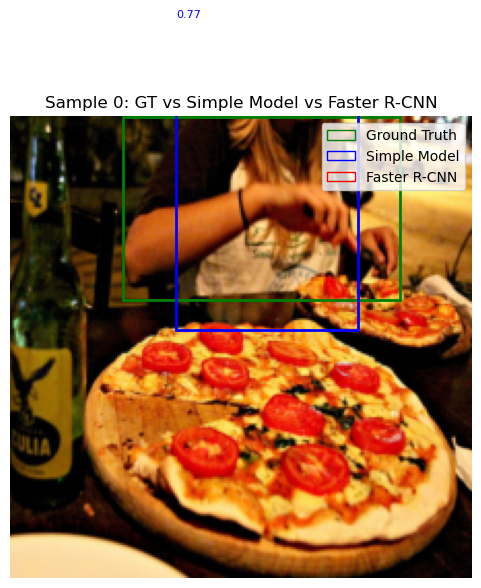

In [484]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
def denormalize(tensor, mean, std):
    # tensor: C×H×W on CPU
    img = tensor.clone()
    for c, (m, s) in enumerate(zip(mean, std)):
        img[c] = img[c] * s + m
    img = img.permute(1,2,0).numpy()
    return np.clip(img, 0, 1)
    
# 1) Select two models to compare
model_a = simple_model.eval()
model_b = rcnn_model.eval()

# 2) Grab one batch and prepare images
images, raw_targets = next(iter(val_loader))
images = [img.to(device) for img in images]

# 3) Pick an index to visualize
idx = 0

# 4) Get ground-truth boxes for that index
gt_boxes = raw_targets[idx]['boxes']  # already a Tensor [M,4] xyxy on CPU
gt_boxes = gt_boxes.cpu()

# 5) Run both models on the batch
with torch.no_grad():
    preds_a = model_a(images)
    preds_b = model_b(images)

# 6) Extract predictions for index `idx`, apply a score threshold
thresh = 0.7

boxes_a  = preds_a[idx]['boxes'].cpu()
scores_a = preds_a[idx]['scores'].cpu()
keep_a   = scores_a > thresh
boxes_a  = boxes_a[keep_a]
scores_a = scores_a[keep_a]

boxes_b  = preds_b[idx]['boxes'].cpu()
scores_b = preds_b[idx]['scores'].cpu()
keep_b   = scores_b > thresh
boxes_b  = boxes_b[keep_b]
scores_b = scores_b[keep_b]

# 7) Plot
mean = [0.485,0.456,0.406]
std  = [0.229,0.224,0.225]

img = images[idx].cpu()                  # C×H×W
img = denormalize(img, mean, std)        # H×W×C in [0..1]
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(img)

# Ground truth in green
for box in gt_boxes:
    x1,y1,x2,y2 = box.numpy()
    ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                   edgecolor='g', fill=False, linewidth=2))
# Model A (simple) in blue
for box, score in zip(boxes_a, scores_a):
    x1,y1,x2,y2 = box.numpy()
    ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                   edgecolor='b', fill=False, linewidth=2))
    ax.text(x1, y1, f"{score:.2f}", color='b', fontsize=8)

# Model B (Faster RCNN) in red
for box, score in zip(boxes_b, scores_b):
    x1,y1,x2,y2 = box.numpy()
    ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                   edgecolor='r', fill=False, linewidth=2))
    ax.text(x1, y2, f"{score:.2f}", color='r', fontsize=8)

# Legend
handles = [
    patches.Patch(edgecolor='g', facecolor='none', label='Ground Truth'),
    patches.Patch(edgecolor='b', facecolor='none', label='Simple Model'),
    patches.Patch(edgecolor='r', facecolor='none', label='Faster R-CNN'),
]
ax.legend(handles=handles, loc='upper right')

ax.set_title(f"Sample {idx}: GT vs Simple Model vs Faster R-CNN")
ax.axis("off")
plt.show()


In [104]:
history

{'train': [{'train/total_loss': 0.5303619154691697},
  {'train/total_loss': 0.4201170165538788},
  {'train/total_loss': 0.4039392355084419},
  {'train/total_loss': 0.38936425775289535},
  {'train/total_loss': 0.3813887140750885},
  {'train/total_loss': 0.37360388177633286},
  {'train/total_loss': 0.36638648837804794},
  {'train/total_loss': 0.3602212198376656},
  {'train/total_loss': 0.35582177072763443},
  {'train/total_loss': 0.3490758675336838}],
 'val': [{'val/map': 0.01441984623670578,
   'val/map_50': 0.05527571216225624,
   'val/map_75': 0.004383445717394352,
   'val/map_small': 0.0054793935269117355,
   'val/map_medium': 0.029214955866336823,
   'val/map_large': 0.06544840335845947,
   'val/mar_1': 0.01348178181797266,
   'val/mar_10': 0.06206477805972099,
   'val/mar_100': 0.11145748943090439,
   'val/mar_small': 0.017699724063277245,
   'val/mar_medium': 0.2269679307937622,
   'val/mar_large': 0.28313252329826355,
   'val/map_per_class': 0.01441984623670578,
   'val/mar_100_p

In [110]:
pytorch_total_params = sum(p.numel() for p in rcnn_model.parameters() if p.requires_grad)
pytorch_total_params

22869830

In [106]:
sum(p.numel() for p in simple_model.parameters() if p.requires_grad)


16053500

# Порівняння моделей та оптимізаторів

In [340]:
def make_simple():
    backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2).features
    backbone.out_channels = 1280
    for param in backbone.parameters():
        param.requires_grad = False
    return SimpleDetector(num_classes, backbone)

def make_frcnn():
    backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2).features
    backbone.out_channels = 1280
    for param in backbone.parameters():
        param.requires_grad = False
    anchor_gen = AnchorGenerator(sizes=((16, 32, 64, 128),),
                                 aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    in_channels_head = backbone.out_channels * 7 * 7
    representation_size = 128
    box_head = TwoMLPHead(
        in_channels=in_channels_head,
        representation_size=representation_size
    )
    
    # 5) make a predictor off that (256 → num_classes)
    box_predictor = FastRCNNPredictor(
        in_channels=representation_size,
        num_classes=num_classes
    )
    
    # 6) assemble the Faster R-CNN
    model = FasterRCNN(
        backbone=backbone,
        num_classes=None,                   # we’ll plug in our own predictor
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        box_head=box_head,
        box_predictor=box_predictor
    )
    # model = FasterRCNN(backbone=backbone,
    #                    num_classes=num_classes,
    #                    rpn_anchor_generator=anchor_gen,
    #                    box_roi_pool=roi_pooler)
    return model

In [342]:
experiments = {
    'Custom_SGD':            (make_simple, 'sgd',   False),
    'Custom_SGD_Sched':      (make_simple, 'sgd',   True),
    'Custom_AdamW':          (make_simple, 'adamw', False),
    'Custom_AdamW_Sched':    (make_simple, 'adamw', True),
    'FRCNN_SGD':             (make_frcnn,  'sgd',   False),
    'FRCNN_SGD_Sched':       (make_frcnn,  'sgd',   True),
    'FRCNN_AdamW':           (make_frcnn,  'adamw', False),
    'FRCNN_AdamW_Sched':     (make_frcnn,  'adamw', True),
}
# Run each experiment
results = {}
trained_models = {}

In [350]:
import gc
for name, (factory, opt_name, use_sched) in experiments.items():
    if 'Custom' not in name:
        continue
    model = factory().to(device)
    if opt_name == 'sgd':
        optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-3, momentum=0.9, weight_decay=1e-4)
    else:
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) if use_sched else None

    history = run_training(model, loader, val_loader, optimizer, device, epochs=10, lr_scheduler=scheduler)
    results[name] = history
    # trained_models[name] = model
    
    model.cpu()                           # move weights back to CPU
    del model, optimizer, scheduler       # drop references
    gc.collect()                          # hint Python to collect garbage
    torch.cuda.empty_cache()              # free up all unused cached memory


Validation ▶️ mAP@.50=0.0000, Precision=0.0000, Recall=0.0000, Avg IoU=0.0000


Validation ▶️ mAP@.50=0.0099, Precision=0.7692, Recall=0.0040, Avg IoU=0.5865


Validation ▶️ mAP@.50=0.0204, Precision=0.5310, Recall=0.0243, Avg IoU=0.6279


Validation ▶️ mAP@.50=0.0203, Precision=0.4706, Recall=0.0259, Avg IoU=0.6289


Validation ▶️ mAP@.50=0.0235, Precision=0.4100, Recall=0.0332, Avg IoU=0.6294


Validation ▶️ mAP@.50=0.0289, Precision=0.4525, Recall=0.0405, Avg IoU=0.6320


Validation ▶️ mAP@.50=0.0268, Precision=0.4692, Recall=0.0401, Avg IoU=0.6253


Validation ▶️ mAP@.50=0.0298, Precision=0.4449, Recall=0.0441, Avg IoU=0.6277


Validation ▶️ mAP@.50=0.0304, Precision=0.4646, Recall=0.0425, Avg IoU=0.6320


Validation ▶️ mAP@.50=0.0307, Precision=0.4739, Recall=0.0441, Avg IoU=0.6245


Validation ▶️ mAP@.50=0.0000, Precision=0.0000, Recall=0.0000, Avg IoU=0.0000


Validation ▶️ mAP@.50=0.0099, Precision=0.6000, Recall=0.0036, Avg IoU=0.6214


Validation ▶️ mAP@.50=0.0160, Precision=0.5632, Recall=0.0198, Avg IoU=0.6117


Validation ▶️ mAP@.50=0.0188, Precision=0.4038, Recall=0.0255, Avg IoU=0.6252


Validation ▶️ mAP@.50=0.0234, Precision=0.4335, Recall=0.0356, Avg IoU=0.6116


Validation ▶️ mAP@.50=0.0244, Precision=0.4070, Recall=0.0328, Avg IoU=0.6073


Validation ▶️ mAP@.50=0.0224, Precision=0.4525, Recall=0.0328, Avg IoU=0.5965


Validation ▶️ mAP@.50=0.0221, Precision=0.4451, Recall=0.0328, Avg IoU=0.6090


Validation ▶️ mAP@.50=0.0242, Precision=0.4215, Recall=0.0381, Avg IoU=0.5976


Validation ▶️ mAP@.50=0.0235, Precision=0.4412, Recall=0.0364, Avg IoU=0.5973


Validation ▶️ mAP@.50=0.0194, Precision=0.4275, Recall=0.0239, Avg IoU=0.6026


Validation ▶️ mAP@.50=0.0427, Precision=0.5481, Recall=0.0530, Avg IoU=0.6354


Validation ▶️ mAP@.50=0.0640, Precision=0.4522, Recall=0.0862, Avg IoU=0.6457


Validation ▶️ mAP@.50=0.0615, Precision=0.4925, Recall=0.0794, Avg IoU=0.6584


Validation ▶️ mAP@.50=0.0592, Precision=0.5294, Recall=0.0765, Avg IoU=0.6439


Validation ▶️ mAP@.50=0.0694, Precision=0.5492, Recall=0.0814, Avg IoU=0.6459


Validation ▶️ mAP@.50=0.0661, Precision=0.4909, Recall=0.0870, Avg IoU=0.6480


Validation ▶️ mAP@.50=0.0722, Precision=0.4507, Recall=0.0943, Avg IoU=0.6351


Validation ▶️ mAP@.50=0.0708, Precision=0.4481, Recall=0.0927, Avg IoU=0.6473


Validation ▶️ mAP@.50=0.0664, Precision=0.3810, Recall=0.0992, Avg IoU=0.6310


Validation ▶️ mAP@.50=0.0129, Precision=0.5312, Recall=0.0138, Avg IoU=0.6271


Validation ▶️ mAP@.50=0.0464, Precision=0.4985, Recall=0.0652, Avg IoU=0.6378


Validation ▶️ mAP@.50=0.0557, Precision=0.4662, Recall=0.0753, Avg IoU=0.6318


Validation ▶️ mAP@.50=0.0616, Precision=0.5254, Recall=0.0753, Avg IoU=0.6423


Validation ▶️ mAP@.50=0.0683, Precision=0.5113, Recall=0.0822, Avg IoU=0.6434


Validation ▶️ mAP@.50=0.0696, Precision=0.5221, Recall=0.0862, Avg IoU=0.6509


Validation ▶️ mAP@.50=0.0657, Precision=0.5061, Recall=0.0838, Avg IoU=0.6474


Validation ▶️ mAP@.50=0.0703, Precision=0.5399, Recall=0.0822, Avg IoU=0.6490


Validation ▶️ mAP@.50=0.0634, Precision=0.5227, Recall=0.0794, Avg IoU=0.6451


Validation ▶️ mAP@.50=0.0694, Precision=0.5285, Recall=0.0826, Avg IoU=0.6551


In [351]:
results.keys()

dict_keys(['FRCNN_SGD', 'FRCNN_SGD_Sched', 'FRCNN_AdamW', 'FRCNN_AdamW_Sched', 'Custom_SGD', 'Custom_SGD_Sched', 'Custom_AdamW', 'Custom_AdamW_Sched'])

In [230]:
torch.cuda.empty_cache()

In [317]:
rcnn_model.cpu()                           # move weights back to CPU
del rcnn_model, optimizer, scheduler       # drop references
gc.collect()                          # hint Python to collect garbage
torch.cuda.empty_cache()              # free up all unused cached memory


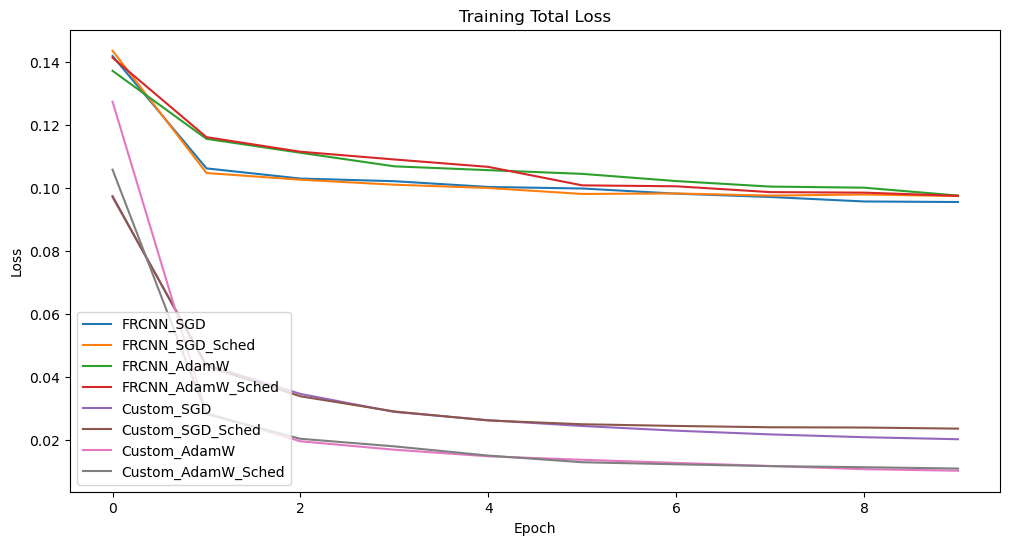

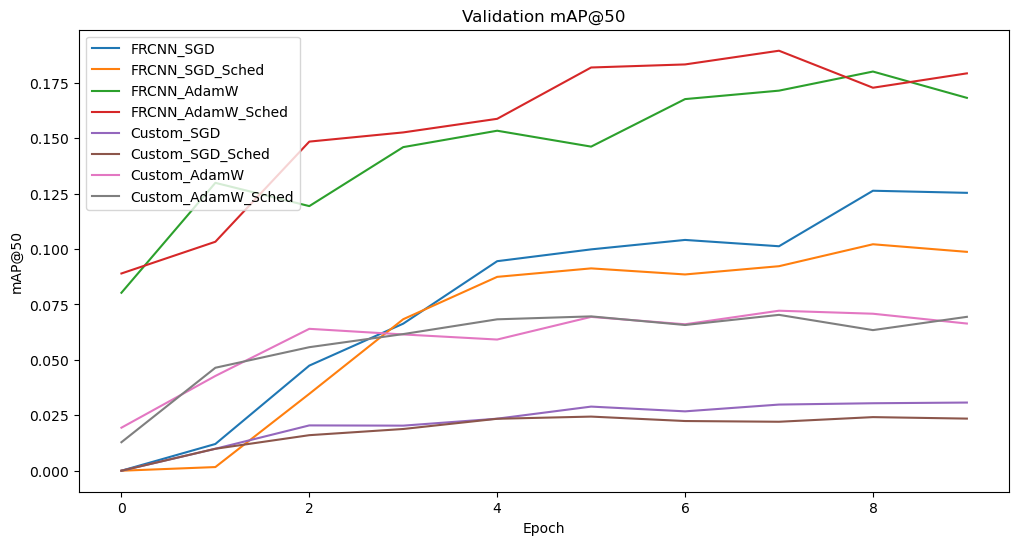

In [368]:
import pandas as pd
import matplotlib.pyplot as plt

# assumes `results` dict is in scope with keys as method names and values as history dicts
# 1) Build DataFrame for training loss
train_loss = {
    name: [epoch['train/total_loss'] for epoch in history['train']]
    for name, history in results.items()
}
df_train = pd.DataFrame(train_loss)

# Plot training loss
plt.figure(figsize=(12, 6), dpi=100)
for col in df_train.columns:
    plt.plot(df_train[col], label=col)
plt.title("Training Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 2) Build DataFrame for validation mAP@50
val_map50 = {
    name: [epoch['val/map_50'] for epoch in history['val']]
    for name, history in results.items()
}
df_val_map50 = pd.DataFrame(val_map50)

# Plot validation mAP@50
plt.figure(figsize=(12, 6), dpi=100)
for col in df_val_map50.columns:
    plt.plot(df_val_map50[col], label=col)

plt.title("Validation mAP@50")
plt.xlabel("Epoch")
plt.ylabel("mAP@50")
plt.legend()
plt.show()
